Dependecies and collecting images using openCV

In [1]:
import tensorflow as tf
tf.__version__

'2.17.0'

In [2]:
import matplotlib.pyplot as plt
import json
import numpy as np


In [3]:
import os
import time
import uuid
import cv2


In [4]:
IMAGES_PATH = os.path.join('data', 'images')
number_images = 50

In [ ]:
import cv2
cap = cv2.VideoCapture(0)
# Check if the camera opened successfully
if not cap.isOpened():
    print("Error opening video stream or file")
    exit() 

for imgnum in range(number_images):
  print('Collecting image {}'.format(imgnum))
  ret, frame = cap.read()
  # Check if a frame was successfully read
  if not ret:
      print("Can't receive frame (stream end?). Exiting ...")
      break
  imgname = os.path.join(IMAGES_PATH, f'{str(uuid.uuid1())}.jpg')
  cv2.imwrite(imgname, frame)
  cv2.imshow('frame', frame)
  time.sleep(0.5)

  if cv2.waitKey(1) & 0xFF == ord('q'):
    break

cap.release()
cv2.destroyAllWindows()

In [5]:
!labelme

Review dataset and build image loading function

In [6]:
gpu = tf.config.list_physical_devices('GPU')
len(gpu)

0

In [ ]:
# Load images into TF data pipeline
images = tf.data.Dataset.list_files('data\\images\\*.jpg', shuffle=True)
images.as_numpy_iterator().next()

In [9]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [ ]:
images = images.map(load_image)
images.as_numpy_iterator().next()

In [13]:
type(images)

tensorflow.python.data.ops.map_op._MapDataset

In [ ]:
# View images
image_generator = images.batch(4).as_numpy_iterator()
plot_images = image_generator.next()

fig, ax =plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()


Partition Unaugmented Data

In [12]:
# move the matching labels
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data',folder,'images')):

        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath):
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath,new_filepath)



SETUP ALBUMENTATIONS TRANSFORM PIPELINE

In [13]:
import albumentations as alb
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450),
                         alb.HorizontalFlip(p=0.5),
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2),
                         alb.RGBShift(p=0.2),
                         alb.VerticalFlip(p=0.5)],
                         bbox_params= alb.BboxParams(format='albumentations',
                                                     label_fields=['class_labels']))

In [14]:
img = cv2.imread(os.path.join('data','train','images','1a7b2367-6b92-11ef-9285-a511a15c1722.jpg'))
img.shape

(480, 640, 3)

In [15]:
#Load images
with open(os.path.join('data','train','labels','1a7b2367-6b92-11ef-9285-a511a15c1722.json'),'r') as f:
    label = json.load(f)

In [16]:
label['shapes'][0]['points']

[[228.02139037433156, 104.43850267379679],
 [390.0534759358288, 311.3903743315508]]

In [17]:
#Extract coordinates and rescale to match image resolution
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]
coords

[228.02139037433156, 104.43850267379679, 390.0534759358288, 311.3903743315508]

In [18]:
coords = list(np.divide(coords, [640,480,640,480]))
coords

[0.3562834224598931,
 0.21758021390374332,
 0.6094585561497325,
 0.6487299465240641]

APPLY AUGMENTATIONS AND VIEW RESULTS

In [19]:
augmented = augmentor(image=img, bboxes=[coords],class_labels=['face'])
augmented['bboxes']

[(0.1443256090314915,
  0.22097445038621508,
  0.5043969102792631,
  0.6808674985145573)]

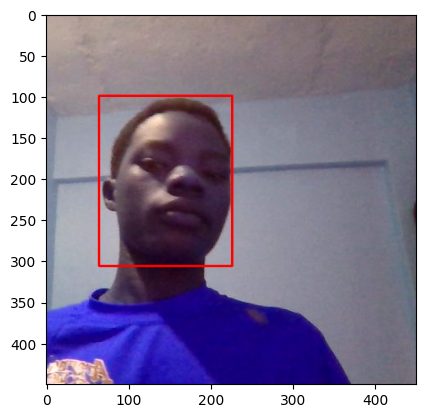

In [21]:
cv2.rectangle(augmented['image'],
              tuple(np.multiply(augmented['bboxes'][0][:2],[450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:],[450,450]).astype(int)),
              (255,0,0),2)

plt.imshow(augmented['image'])

BUILD AND RUN AUGMENTATION PIPELINE

In [24]:
for partition in ['train','test','val']:
    for image in os.listdir(os.path.join('data',partition,'images')):
        img = cv2.imread(os.path.join('data',partition,'images',image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data',partition,'labels',f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try:
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data',partition, 'images', f'{image.split(".")[0]}.{x}.jpg'),augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0:
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0

                    else:
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1

                else:
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0

                with open(os.path.join('aug_data',partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

x_max is less than or equal to x_min for bbox [0.32286096256684493, 0.9974376114081996, 0.051303475935828936, 0.7166889483065954, 'face'].


LOAD AUGMENTED IMAGES TO TENSORFLOW DATASET

In [25]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = train_images.map(lambda x: x/255)

val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [26]:
train_images.as_numpy_iterator().next()

array([[[0.67947304, 0.75055146, 0.8510417 ],
        [0.6509804 , 0.7372549 , 0.827451  ],
        [0.64656866, 0.7372549 , 0.82303923],
        ...,
        [0.45588234, 0.47254902, 0.5470588 ],
        [0.4403799 , 0.4596201 , 0.5341299 ],
        [0.44381127, 0.45851716, 0.53302693]],

       [[0.6789216 , 0.75735295, 0.85490197],
        [0.6582721 , 0.74601716, 0.8356005 ],
        [0.64577204, 0.7442402 , 0.8213848 ],
        ...,
        [0.46121323, 0.46415442, 0.5416054 ],
        [0.45251226, 0.45545343, 0.5260417 ],
        [0.4648897 , 0.4699755 , 0.5331495 ]],

       [[0.67971814, 0.75085783, 0.8326593 ],
        [0.65833336, 0.7480392 , 0.82009804],
        [0.63976717, 0.72996324, 0.8005515 ],
        ...,
        [0.48670343, 0.48278186, 0.5533701 ],
        [0.47457108, 0.4706495 , 0.534375  ],
        [0.47653186, 0.46770832, 0.5378064 ]],

       ...,

       [[0.5466299 , 0.45      , 0.3841299 ],
        [0.54767156, 0.45386028, 0.38921568],
        [0.60183823, 0